*Antonio Coín Castro      
13/01/2021*

In [1]:
from pylab import rcParams
import examen_ordinaria_PE_2020_2021 as pe
import BM_simulators as bm
import stochastic_plots as stoch
from sde_solvers import euler_maruyana  # entrega HW02
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 10, 5

# Author: <alberto.suarez@uam.es>

np.random.seed(42)

# Exercise 1: Simulation of a Continuous-time Markov Chain

## Continuous-time Markov Chain

**f)** Simula trayectorias del proceso suponiendo que en el instante $t=0$ el proceso se encuentra en el estado $S_0=0$. 

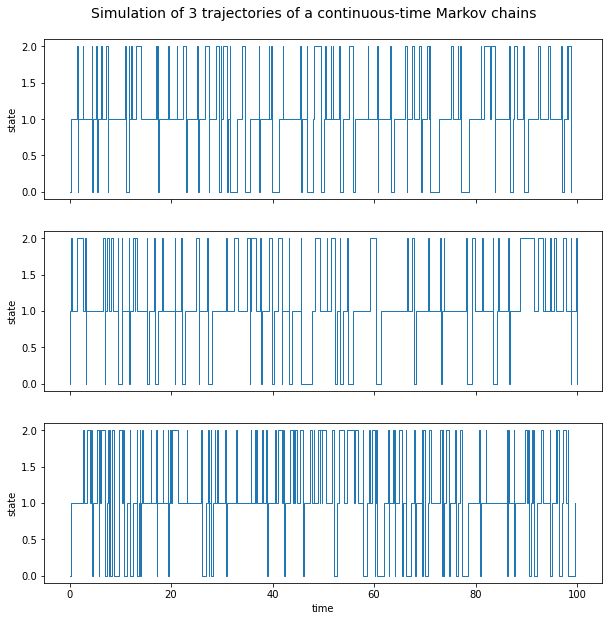

In [2]:
transition_matrix = [[0, 1, 0],
                     [0, 0, 1],
                     [1/2, 1/2, 0]]
lambda_rates = [2, 1, 3]
t0 = 0.0
t1 = 100.0
state_0 = 0

# Simulate trajectories
M = 3  # Number of simulations
arrival_times_CTMC, trajectories_CTMC = (
    pe.simulate_continuous_time_Markov_Chain(
        transition_matrix, lambda_rates,
        state_0, M, t0, t1))

# Plot trajectories
fig, ax = plt.subplots(M, 1, figsize=(10, 10), num=1, sharex=True)
plt.suptitle(
    f'Simulation of {M} trajectories of a continuous-time Markov chains',
    y=0.925,
    size=14)
plt.xlabel('time')
for m in range(M):
    ax[m].step(arrival_times_CTMC[m],
               trajectories_CTMC[m],
               where='post',
               lw=1)
    ax[m].set_ylabel('state')

**g.1)** Estima la distribución estacionaria del proceso de saltos subyacente a partir de una única trayectoria de la cadena de Markov en tiempo continuo.

Podemos estimar esta distribución estacionaria con la media muestral de una única trayectoria: contar el número de veces que la cadena pasa por cada estado y dividir por el número total de transiciones.

In [3]:
# Utilizamos la primera simulación que hicimos antes
_, states_count = np.unique(trajectories_CTMC[0], return_counts=True)
stationary_dist = states_count / np.sum(states_count)
print("Distribución estacionaria estimada para el proceso de saltos:")
print(stationary_dist)

Distribución estacionaria estimada para el proceso de saltos:
[0.2147651  0.39597315 0.38926174]


Vemos que estas cantidades coinciden aproximadamente con la distribución estacionaria teórica, que era

$$(1/5, 2/5, 2/5).$$

Si utilizásemos más simulaciones e hiciéramos la media, la aproximación obtenida sería más precisa.

**g.2)** Estima la distribución estacionaria de la cadena de Markov en tiempo continuo a partir de una
única trayectoria del proceso.

De nuevo utilizamos una aproximación basada en la media muestral (para una única simulación). Calculamos el tiempo que pasamos en cada estado y lo dividimos por el tiempo total de la simulación.

In [4]:
# Utilizamos de nuevo la primera simulación
n_states = len(lambda_rates)
trajectories = np.array(trajectories_CTMC[0])
# Añadimos el tiempo final por conveniencia
arrival_times = np.array(arrival_times_CTMC[0] + [t1])

# Buscamos los instantes en los que llegamos a cada estado
mask = [np.where(trajectories == i)[0] for i in range(n_states)]

# Contamos el tiempo total que pasamos en cada estado
times_count = np.array([np.sum(
    arrival_times[mask[i] + 1] - arrival_times[mask[i]])
    for i in range(n_states)])

stationary_dist_cont = times_count / (t1 - t0)
print(
    "Distribución estacionaria estimada para la cadena en tiempo continuo:")
print(stationary_dist_cont)

Distribución estacionaria estimada para la cadena en tiempo continuo:
[0.15326885 0.67999664 0.16673451]


De nuevo, la distribución estacionaria estimada coincide aproximadamente con la teórica, que hemos visto que es

$$(3/19, 12/19, 4/19).$$

**g.3)** Estima la distribución de la cadena de Markov en tiempo continuo en el límite $t\to \infty$ a partir
de los estados finales en $M = 1000$ trayectorias simuladas.

Calculamos la proporción de veces que acabamos la simulación en cada estado.



In [5]:
M = 1000  # Number of simulations
arrival_times_CTMC, trajectories_CTMC = (
    pe.simulate_continuous_time_Markov_Chain(
        transition_matrix, lambda_rates,
        state_0, M, t0, t1))

In [6]:
final_states = [trajectory[-1] for trajectory in trajectories_CTMC]
_, final_states_count = np.unique(final_states, return_counts=True)
stationary_dist_final = final_states_count / np.sum(final_states_count)
print(
    "Distribución estacionaria estimada para para la cadena en tiempo continuo:")
print(stationary_dist_final)

Distribución estacionaria estimada para para la cadena en tiempo continuo:
[0.169 0.616 0.215]


También coincide con la distribución teórica. Aunque no habíamos hecho el desarrollo partiendo de la distribución en el límite $t\to\infty$, ya sabíamos que debían coincidir, gracias al siguiente teorema:

**Teorema.** Si existe una distribución estacionaria $\pi$ para una cadena de Markov en tiempo continuo, entonces es única y verifica:
$$\forall i \quad \pi_j = \lim_{t\to\infty} p_{ij}(t).\quad$$

## Exercise 2: Simulation of a Brownian bridge process

### Expected value of the standard Wiener process

Consider the expression for the standard Brownian bridge
$$ 
BB_{std}(t) = W(t) - W(1) \, t 
$$

The mean of this process is
$$ 
\mathbb{E}\left[ BB_{std}(t) \right] = \mathbb{E}\left[ W(t) - W(1) \, t \right]
$$
The expected value operator is linear. Therefore, 
$$ 
\mathbb{E}\left[ BB_{std}(t) \right] = \mathbb{E}\left[ W(t) \right] - \mathbb{E}\left[ W(1) \right] t.
$$
Since process $W(t)$ has zero mean $\mathbb{E}\left[ W(t) \right] = 0, \ \forall t \ge 0$
$$ 
\mathbb{E}\left[ BB_{std}(t) \right] = 0, \quad \forall t \in \left[0, 1 \right].
$$

### Covariance function for the standard Brownian bridge

The covariance function for the standard Brownian bridge is defined as
$$ 
\gamma(t,s) = 
 \mathbb{E} \left[\left(BB_{std}(s) - \mathbb{E}\left[ BB_{std}(s) \right] \right)  \left(BB_{std}(t)  - \mathbb{E}\left[ BB_{std}(t) \right] \right)\right]. 
$$ 
Using 
$$ 
BB_{std}(t) = W(t) - W(1) \, t, \quad \mathbb{E}\left[ BB_{std}(t) \right] = 0
,$$ 
and 
$$
\gamma(s, t) = 
 \mathbb{E} \left[ \left(W(s) - W(1) \, s \right) \left(W(t) - W(1) \,  t \right)\right] =
 \mathbb{E} \left[ W(s) W(t) \right]  + \mathbb{E} \left[W^2(1)\right] s t - \mathbb{E} \left[W(1) W(t)\right] \, s 
- \mathbb{E} \left[W(s) W(1) \right]  \, t. 
$$ 
Finally, taking into account that
$$ 
\mathbb{E}\left[ W(s) W(t) \right] = \min(s, t), $$ 
one gets 
$$ 
\gamma(s, t) =  \min(s, t) + s t - t s - s t = \min(s, t) - s t. 
$$ 


### Mean function for a general Brownian bridge

We know that for a general Brownian bridgen in $[t_0, t_1]$ with $BB(t_0)=BB_0$ and $BB(t_1)=BB_1$, we have

$$BB(t)=B(t)+ (BB_1-B(t_1))\frac{t-t_0}{t_1-t_0},$$

where $B(t)$ is a general arithmetic Brownian motion with $\mu=0, \sigma>0$ and $B(t_0)=BB_0$.

To derive the mean function for $BB(t)$, we take expected values:

$$\mathbb E[BB(t)]=\mathbb E[B(t)] + (BB_1 - \mathbb E[B(t_1)])\frac{t-t_0}{t_1-t_0}.$$

Now, we recall that $B(t)$ can be expressed as

$$B(t)=B(t_0) + \mu(t-t_0) + \sigma\sqrt{t-t_0}Z, \quad Z \sim \mathcal N(0,1).$$

Substituting $\mu=0, B(t_0)=BB_0$ and taking expected values yields, for an arbitrary $t\in \mathbb R$:

$$\mathbb E[B(t)]=BB_0 + \sigma\sqrt{t-t_0}\mathbb E[Z]=BB_0.$$

Thus, recovering the previous equation, we have:

$$\mathbb E[BB(t)]=BB_0+ (BB_1 - BB_0)\frac{t-t_0}{t_1-t_0}.$$

### Covariance function for a general Brownian bridge

In this case we will use two fundamental properties of the covariance function in a general setting:

- The covariance is a **bilinear** function, that is, $Cov[aX+bY, Z]=aCov[X, Z] + bCov[Y, Z]$ and the analogous happens if the sum is in the second variable.
- The covariance with a (non-random) constant is always 0: $Cov(X, c)=0$.

Remember that in general the autocovariance function of a process $X(t)$ is defined as

$$\gamma(t, s)=Cov[X(t), X(s)].$$

Then, we have, for arbitrary $t_0\leq t, s \leq t_1$:

$$
\begin{aligned}
Cov[BB(t), BB(s)]&=Cov\left[B(t) + (BB_1 - B(t_1))\frac{t-t_0}{t_1-t_0}, [B(s) + (BB_1 - B(t_1))\frac{s-t_0}{t_1-t_0}\right]\\
&= Cov\left[ B(t) + \overbrace{BB_1\frac{t-t_0}{t_1-t_0}}^{constant} - B(t_1)\frac{t-t_0}{t_1-t_0}, B(s) + \overbrace{BB_1\frac{s-t_0}{t_1-t_0}}^{constant} - B(t_1)\frac{s-t_0}{t_1-t_0}\right]\\
&= Cov[B(t), B(s)] - \frac{s-t_0}{t_1-t_0}Cov[B(t), B(t_1)] - \frac{t-t_0}{t_1-t_0}Cov[B(t_1), B(s)] + \frac{(s-t_0)(t-t_0)}{(t_1-t_0)^2}Cov[B(t_1), B(t_1)].
\end{aligned}
$$

Now we will use the fact that the autocovariance function for the Brownian motion $B(t)$ is given by

$$Cov[B(t), B(s)]=\sigma^2\min\{t-t_0, s-t_0\}.$$

Putting it all together, we get:

$$
\begin{aligned}
Cov[BB(t), BB(s)]&=\sigma^2\min\{t-t_0, s-t_0\} - \frac{s-t_0}{t_1-t_0}\sigma^2\min\{t-t_0, t_1-t_0\}\\
&- \frac{t-t_0}{t_1-t_0}\sigma^2\min\{t_1-t_0, s-t_0\} + \sigma^2\min\{t_1-t_0, t_1-t_0\}\frac{(s-t_0)(t-t_0)}{(t_1-t_0)^2}\\
&= \sigma^2\left(\min\{t-t_0, s-t_0\} - \frac{(s-t_0)(t-t_0)}{t_1-t_0}\right).
\end{aligned}
$$

### Brownian bridge simulation

We wish to simulate the covariance function $\gamma(t, t_{ref})$ for a particular Brownian Bridge. For this task we will use the theoretical expression

$$
\gamma(t,t_{ref}) = 
 \mathbb{E} \left[\left(BB(t) - \mathbb{E}\left[ BB(t) \right] \right)  \left(BB(t_{ref})  - \mathbb{E}\left[ BB(t_{ref}) \right] \right)\right],
$$ 

substituting expected values by empirical means.

We set $t_{ref}=5.3$, and consider a Brownian bridge process  $BB$ in $[4, 7]$ with $\sigma=2$, verifying $BB(4)=1$ and $BB(7)=3$. For the simulation we consider $N=100$ time steps and a sufficient number of simulated trajectories, say $M=5000$. One thing to take into account is that with this time discretization we do not get the exact value of $t_{ref}$ in the grid. We make the decision to select the closest time value that is greater than $t_{ref}$. If we wanted more precision, we coul increase the value of $N$, or even consider a linear interpolation between the two closest values to $t_{ref}$ on the grid. 

In [7]:
# Brownian bridge simulation
M = 5000
N = 100
sigma = 2.0
t0, t1 = 4.0, 7.0
B0, B1 = 1.0, 3.0
t_grid, BB_trajectories = bm.simulate_Brownian_bridge(
    t0, B0, t1, B1, sigma, M, N)

# Index of tref
tref = 5.3
tref_index = np.where(t_grid >= tref)[0][0]

# Compute sample covariance
simulated_cov = [np.mean((BB_trajectories[:, t]
                          - np.mean(BB_trajectories[:, t])) *
                         (BB_trajectories[:, tref_index]
                          - np.mean(BB_trajectories[:, tref_index])))
                 for t in range(len(t_grid))]

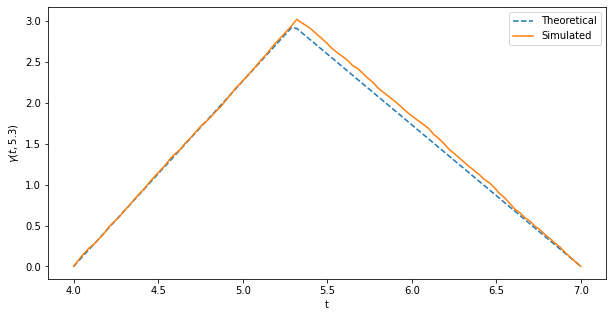

In [8]:
# Theoretical autocovariance function
def theoretical_cov(t, s, sigma, t1, t0):
    return sigma**2 * (np.minimum(t-t0, s-t0) - ((s-t0)*(t-t0))/(t1-t0))


plt.plot(t_grid, theoretical_cov(t_grid, tref, sigma, t1, t0), "--",
         label="Theoretical")
plt.plot(t_grid, simulated_cov, label="Simulated")
plt.xlabel("t")
plt.ylabel(r"$\gamma(t, 5.3)$")
plt.legend()
_ = plt.show()

We can see that the estimation is very close to the real function.

# Exercise 3: Simulation of a stochastic volatility model

### Derivation of $\mathbb{E}\left[\sigma(t)\right]$

Consider the Ito SDE
$$
d \sigma(t) = - \alpha \left( \sigma(t) -  \sigma_{\infty} \right) dt + \xi dW(t),   
$$
where $\alpha > 0$ is the reversion rate, $\xi > 0$ is the volatility of the stochastic process $\sigma(t)$. 

Define the process $X(t) = \sigma(t) - \sigma_{\infty}$. Since $ \sigma_{\infty} $ is constant, $dX(t) = d \sigma(t)$, and the equation becomes
$$
d X(t) = - \alpha X(t) dt + \xi dW(t).
$$


Let's take the expected value on both sizes of the equation 
$$
\mathbb{E}\left[dX(t) \right] = \mathbb{E}\left[ - \alpha  X(t) dt + \xi  dW(t) \right].
$$

Using the fact that the expected value is a linear operator, we get
$$
d\mathbb{E} \left[X(t) \right] = - \alpha \mathbb{E}\left[ X(t) \right] dt + \xi \mathbb{E}\left[ dW(t) \right].
$$
Since the Wiener process has zero mean, the equation becomes 
$$
d \mathbb{E} \left[ X(t) \right] = - \alpha  \mathbb{E} \left[ X(t) \right] dt.
$$
Using the method of separation of variables
$$
\frac{1}{ \mathbb{E} \left[ X(t) \right]} d \mathbb{E} \left[ X(t) \right] = - \alpha dt,
$$
the equation can be integrated between $(t_0, X_0)$, where $X_0 = \sigma_0 - \sigma_{\infty}$, and $\left(t,  \mathbb{E} \left[ X(t) \right] \right)$
$$
\int_{X_0}^{\mathbb{E} \left[ X(t) \right]} \frac{1}{ \mathbb{E} \left[ X \right]} d \mathbb{E} \left[ X \right]  = - \alpha \int_{t_0}^t d\tau. 
$$
The solution is
$$
\log \frac{ \mathbb{E}\left[X(t) \right] }{ X_0 } = - \alpha \left(t- t_0 \right).
$$
After some straightforward algebraic manipulation, one obtains
$$
\mathbb{E} \left[ X(t) \right] =  X_0  e^{- \alpha \left(t- t_0 \right)}.
$$
Undoing the change of variable, we obtain
$$
\mathbb{E} \left[ \sigma(t) \right] = \sigma_{\infty} + \left(\sigma_0  - \sigma_{\infty} \right)  e^{- \alpha \left(t- t_0 \right)}.
$$

### Simulation of the SDE $
d \sigma(t) = - \alpha \left( \sigma(t) -  \sigma_{\infty} \right) dt + \xi dW(t),   
$


We simulate a process and show a few trajectories, showing the evolution of the mean and of the interval that, on average, contains 99% of the distribution, which, since we know the distribution is Gaussian, is (see [Wikipedia](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)):

$$(X_{mean} - 3X_{std}, X_{mean}+3 X_{std})$$

In [9]:
# Define SDE
alpha = 0.3
sigma_inf = 0.5
xi = 0.2


def a(t, x): return -alpha * (x - sigma_inf)
def b(t, x): return xi


# Define initial conditions
t0, sigma0 = 2.5, 2.0

# Define the simulation parameters
M = 10000  # Number of trajectories for simulation
T = 17.5   # Length of simulation interval
N = 100  # Number of steps in simulation

# Carry out simulation
t_grid, X_euler = euler_maruyana(t0, sigma0, T, a, b, M, N)

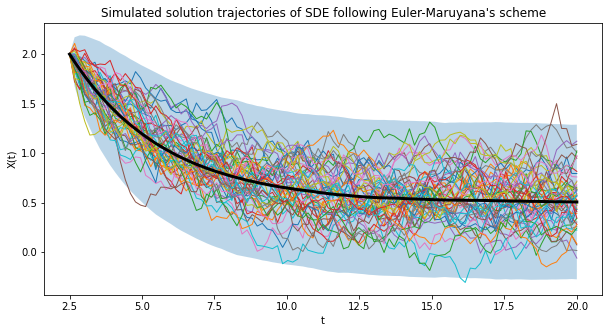

In [10]:
# Plot trajectories
stoch.plot_trajectories(t_grid, X_euler, fig_num=1, max_trajectories=50)
plt.title(
    "Simulated solution trajectories of SDE following Euler-Maruyana's scheme")
mean = np.mean(X_euler, axis=0)
std = np.std(X_euler, axis=0)
a = 3.0
plt.fill_between(t_grid, mean - a*std,
                 mean + a*std, alpha=0.3)
plt.show()

Now we compare the evolution of the theoretical and the empirical mean and variance.

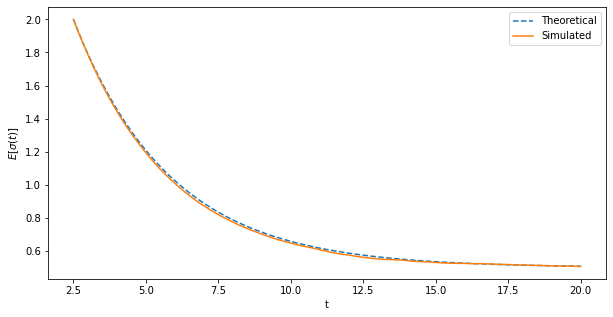

In [11]:
# Theoretical mean
def theoretical_mean(t):
    return sigma_inf + (sigma0 - sigma_inf)*np.exp(-alpha*(t-t0))


plt.plot(t_grid, theoretical_mean(t_grid), "--",
         label="Theoretical")
plt.plot(t_grid, np.mean(X_euler, axis=0), label="Simulated")
plt.xlabel("t")
plt.ylabel(r"$E[\sigma(t)]$")
plt.legend()
_ = plt.show()

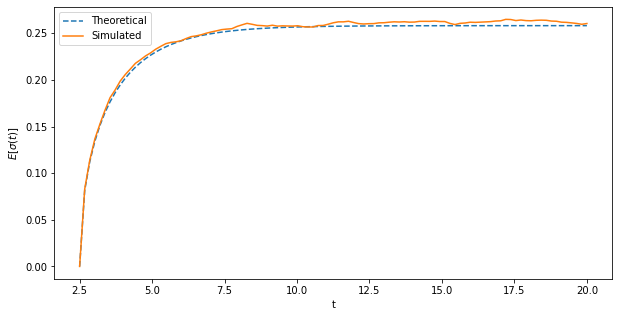

In [12]:
# Theoretical variance function
def theoretical_var(t):
    return (xi**2 / (2*alpha)) * (1-np.exp(-2*alpha*(t-t0)))


plt.plot(t_grid, np.sqrt(theoretical_var(t_grid)), "--",
         label="Theoretical")
plt.plot(t_grid, np.std(X_euler, axis=0), label="Simulated")
plt.xlabel("t")
plt.ylabel(r"$E[\sigma(t)]$")
plt.legend()
_ = plt.show()

Finally, we compute the limiting distribution and compare it to the theoretical one.

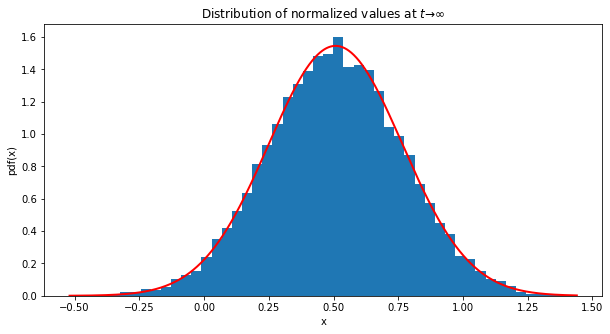

In [13]:
def pdf(x):
    return stats.norm.pdf(x, loc=theoretical_mean(t_grid[-1]),
                          scale=np.sqrt(theoretical_var(t_grid[-1])))


# Asymptotic stationary pdf of the process
xT = X_euler[:, -1]
stoch.plot_pdf(xT, pdf, fig_num=2)
_ = plt.title(r"Distribution of normalized values at $t\to\infty$")

# Exercise 4: Pricing of a European call option

-- No hecho --

## Pricing by quadrature

In [14]:
# Parameters that characterize underlying
S0 = 100.0
sigma = 0.3

# Parameters of the EU call option
K = 90.0
T = 2.0

# Risk-free interest rate
r = 0.05

price_EU_call = pe.price_EU_call(S0, K, r, sigma, T)

print('Price = {:.4f}'.format(price_EU_call))

Price = 26.2402


## Monte Carlo pricing of a European call option